In [ ]:
import torch
from yucca.modules.data.augmentation.transforms.YuccaTransform import YuccaTransform


def create_nonzero_mask(data):
    """

    :param data:
    :return: the mask is True where the data is nonzero
    """
    assert data.ndim in (3, 4), "data must have shape (C, X, Y, Z) or shape (C, X, Y)"
    nonzero_mask = data[0] != 0
    for c in range(1, data.shape[0]):
        nonzero_mask |= data[c] > 0
    # mask = binary_fill_holes(nonzero_mask)
    return nonzero_mask


def volume_wise_znorm(x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """
    Normalize the input tensor using volume-wise z-normalization.
    Assumes the input is a 3D tensor (X, Y, Z) or 2D Tensor (X, Y).
    """
    mask = mask.to(dtype=torch.bool, device=x.device)
    m = x[mask].mean()
    s = x[mask].std(unbiased=False).clamp_min(1e-8)
    out = x.clone()
    out[mask] = (x[mask] - m) / s

    return out


class Mask_Normalize(YuccaTransform):
    def __init__(self, normalize: bool = False, data_key: str = "image", fn=volume_wise_znorm):
        self.normalize = normalize
        self.data_key = data_key
        self.fn = fn

    @staticmethod
    def get_params():
        # No parameters to retrieve
        pass

    def __normalize__(self, data_dict):
        mask = create_nonzero_mask(data_dict[self.data_key])
        for c in range(data_dict[self.data_key].shape[0]):
            if isinstance(self.fn, list):
                fn = self.fn[c]
            else:
                fn = self.fn
            data_dict[self.data_key][c] = fn(data_dict[self.data_key][c], mask=mask)
        return data_dict

    def __call__(self, data_dict):
        if self.normalize:
            data_dict = self.__normalize__(data_dict)
        return data_dict

INFO:root:Using 1 workers


####  5  ####
torch.Size([1, 1, 128, 128, 128])
tensor(0.)
tensor(1.)


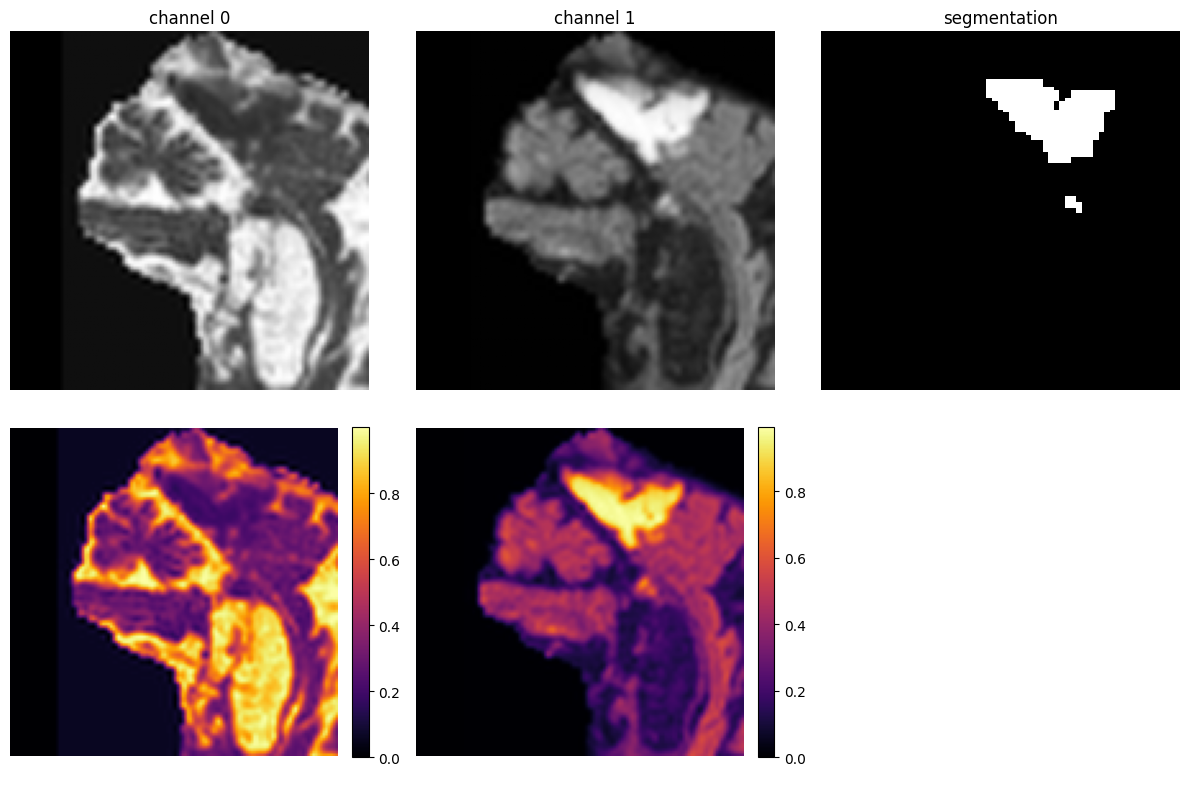

In [ ]:
#!/usr/bin/env python3
import matplotlib.pyplot as plt
from asparagus.modules.data_modules.training import SegDataModule
from batchgenerators.utilities.file_and_folder_operations import load_json
from matplotlib.colors import ListedColormap
from torchvision import transforms
from yucca.functional.array_operations.matrix_ops import get_max_rotated_size
from yucca.modules.data.augmentation.transforms import (
    Torch_Spatial,
)
from yucca.modules.data.augmentation.transforms.cropping_and_padding import Torch_CropPad

patch_size = [128, 128, 128]
p_rot_all_channel = 0.2
p_scale_all_channel = 0.2

if p_rot_all_channel > 0 or p_scale_all_channel > 0:
    pre_aug_patch_size = get_max_rotated_size(patch_size)
else:
    pre_aug_patch_size = patch_size

cpu_transforms = transforms.Compose(
    [
        # Torch_Normalize(normalize=True),
        # Mask_Normalize(normalize=True),
        Torch_CropPad(patch_size=pre_aug_patch_size, p_oversample_foreground=0.4, pad_value=0),
        Torch_Spatial(
            patch_size=patch_size,
            p_deform_all_channel=0.0,
            p_rot_all_channel=p_rot_all_channel,
            p_rot_per_axis=0.3,
            p_scale_all_channel=p_scale_all_channel,
            clip_to_input_range=False,
            skip_label=False,
        ),
    ]
)

i = 5

print("#### ", i, " ####")
splits = load_json("/dtu/p1/asbmun/data/asparagus/data/Task601_SEG_ISLES22_experimental/split_40_10_50.json")[0]

data_module = SegDataModule(
    train_split=[splits["train"][i]],
    val_split=splits["val"],
    train_transforms=cpu_transforms,
    val_transforms=None,
    batch_size=1,
    num_workers=1,
)

data_module.setup(stage="fit")

batch = next(iter(data_module.train_dataloader()))
img = batch["image"][0]
label = batch["label"]
print(label.shape)

print(img.min())
print(img.max())

k = 2

segmentation_volume = label[0, 0]  # [Z, Y, X]
foreground_slice_indices = torch.nonzero(segmentation_volume.any(dim=(1, 2)), as_tuple=False).squeeze(1)
if foreground_slice_indices.numel() == 0:
    raise RuntimeError("No labeled voxels found.")

slice_index = int(foreground_slice_indices[k % foreground_slice_indices.numel()])

channel_slices = img[:, slice_index].cpu().numpy()  # [C, Y, X]
segmentation_slice = segmentation_volume[slice_index].cpu().numpy()  # [Y, X]

num_channels = channel_slices.shape[0]
fig, axes = plt.subplots(2, num_channels + 1, figsize=(4 * (num_channels + 1), 8))
if num_channels == 1:
    axes = axes.reshape(2, num_channels + 1)

for ch in range(num_channels):
    axes[0, ch].imshow(channel_slices[ch], cmap="gray")
    axes[0, ch].set_title(f"channel {ch}")
    axes[0, ch].axis("off")

    im = axes[1, ch].imshow(channel_slices[ch], cmap="inferno")
    axes[1, ch].axis("off")
    fig.colorbar(im, ax=axes[1, ch], fraction=0.046, pad=0.04)

axes[0, -1].imshow(segmentation_slice, cmap=ListedColormap(["black", "white"]), vmin=0, vmax=1, interpolation="nearest")
axes[0, -1].set_title("segmentation")
axes[0, -1].axis("off")
axes[1, -1].axis("off")

plt.tight_layout()
plt.show()

In [23]:
import numpy as np

np.prod(np.array([154, 144, 130])) / np.prod(np.array([180, 155, 140]))

np.float64(0.7380645161290322)

In [4]:
load_json("/dtu/p1/asbmun/data/asparagus/data/Task601_SEG_ISLES22_experimental/split_40_10_50.json")[0]["train"][0]

'/dtu/p1/asbmun/data/asparagus/data/Task601_SEG_ISLES22_experimental/ISLES22/ISLES-2022/images/sub-strokecase0111/ses-0001/anat/sub-strokecase0111_ses-0001.pt'